In [41]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import math
import warnings
warnings.filterwarnings('ignore')
def generate_quantum_random_key_bytes(bit_length=256):
    """
    Generates a truly random key by simulating a 1-qubit circuit
    'bit_length' times. This is fast and works on any PC.

    Args:
        bit_length (int): The desired key length in bits (e.g., 256).

    Returns:
        bytes: The raw 32-byte (256-bit) key.
    """

    print(f"Initializing {bit_length}-bit quantum random key generation...")

    # 1. Create a 1-qubit, 1-classical-bit circuit
    # We will measure one qubit into one classical bit.
    qc = QuantumCircuit(1, 1)

    # 2. Apply Hadamard (H) gate to the qubit
    # This puts the qubit in a 50/50 superposition.
    qc.h(0)

    # 3. Measure the qubit
    # Collapse the superposition into a definite 0 or 1.
    qc.measure(0, 0)

    # 4. Run the circuit on the simulator
    simulator = AerSimulator()
    compiled_circuit = transpile(qc, simulator)

    # KEY CHANGE:
    # Run the 1-qubit circuit 'bit_length' times (e.g., 256 shots).
    # 'memory=True' tells the simulator to record the result of *every single shot*.
    job = simulator.run(compiled_circuit, shots=bit_length, memory=True)

    # 5. Get the results
    # .get_memory() returns a list of the results, e.g., ['0', '1', '1', '0', ...]
    memory_results = job.result().get_memory()

    # 6. Join the list into our final binary string
    binary_string = "".join(memory_results)

    if len(binary_string) != bit_length:
        raise ValueError("Error: Did not get the full bit length from the simulator.")

    # 7. Convert the binary string ('101...') into bytes
    random_int = int(binary_string, 2)

    # Calculate the number of bytes needed
    byte_length = math.ceil(bit_length / 8) # e.g., 256 / 8 = 32 bytes

    # Convert the integer to bytes
    random_key_bytes = random_int.to_bytes(byte_length, 'big')

    print("Quantum-generated key (in hex):", random_key_bytes.hex())
    return random_key_bytes

# Run the corrected key generator
# This will be our AES-256 symmetric key
aes_key = generate_quantum_random_key_bytes(bit_length=256)
print(f"\nSuccessfully generated a {len(aes_key)}-byte key (256-bit).")

Initializing 256-bit quantum random key generation...
Quantum-generated key (in hex): b0ccc312b2b4b6cca4297c0114a8082c7bb30fe349a523486405bbcd27c7670f

Successfully generated a 32-byte key (256-bit).


Great. Now we have our 32-byte (256-bit) truly random aes_key.

The next step is to use this key to encrypt your secret message. We'll use AES-256 in GCM mode, which is a fast, secure, and modern standard that also provides authentication (to ensure the data isn't tampered with).

Encrypting the Secret Message
Here is the Python code. This function will take your secret message and the aes_key we just generated, and output the encrypted data.

In [43]:
from cryptography.hazmat.primitives.ciphers.aead import AESGCM
import os

def encrypt_message(key, plaintext_message):
    """
    Encrypts a plaintext message using AES-256 GCM with a given key.

    Args:
        key (bytes): The 32-byte (256-bit) AES key.
        plaintext_message (str): The secret message to encrypt.

    Returns:
        bytes: The combined (nonce + ciphertext + tag) encrypted data.
    """

    # We must use AESGCM for authenticated encryption
    aesgcm = AESGCM(key)

    # Convert your string message to bytes
    plaintext_bytes = plaintext_message.encode('utf-8')

    # Generate a random 12-byte "nonce" (number used once)
    # This MUST be random and unique for every encryption with the same key.
    # It does not need to be secret; we will send it with the ciphertext.
    nonce = os.urandom(12)

    print(f"Encrypting with a 12-byte nonce: {nonce.hex()}")

    # Encrypt the data.
    # This automatically handles padding and generates:
    # 1. The ciphertext
    # 2. An authentication "tag"
    ciphertext_and_tag = aesgcm.encrypt(nonce, plaintext_bytes, None)

    # For simplicity, we'll combine the nonce and the ciphertext+tag.
    # The receiver will need the nonce to decrypt.
    # Structure: [ 12-byte Nonce | Ciphertext | 16-byte Tag ]
    encrypted_payload = nonce + ciphertext_and_tag

    return encrypted_payload

# Run the encryption

# This is the key from our previous Qiskit step.
# For this example, I'll use a placeholder key.
# **REPLACE THIS** with the 'aes_key' variable from your last script.
if 'aes_key' not in locals():
    print("aes_key not found, using a dummy key for this example.")
    aes_key = os.urandom(32) # 32 bytes = 256 bits

print(f"Using AES Key (hex): {aes_key.hex()}")

# This is your secret message
secret = "Let's show Quantum Advantage"

encrypted_data = encrypt_message(aes_key, secret)

print(f"\nPlaintext: '{secret}'")
print(f"Encrypted payload (hex): {encrypted_data.hex()}")
print(f"Total encrypted payload length: {len(encrypted_data)} bytes")

Using AES Key (hex): b0ccc312b2b4b6cca4297c0114a8082c7bb30fe349a523486405bbcd27c7670f
Encrypting with a 12-byte nonce: adb11abdb86ce896e9dfb4bf

Plaintext: 'Let's show Quantum Advantage'
Encrypted payload (hex): adb11abdb86ce896e9dfb4bf84fe93c091d2e57d888a2fb50d30ea23ff3231b89d440db37e7c197b2d42a182403bc514a414e48e581521c4
Total encrypted payload length: 56 bytes


### What just happened?

- We created a secret message: "."

- We used the quantum-generated aes_key to encrypt it.

- The output, encrypted_data, is a jumbled block of bytes. This data is useless to anyone who doesn't have the aes_key.

- The "Quantum-Resistant" Part (Next Step)
- We now have a problem: How do we give the aes_key to the receiver?

- If we just send the aes_key along with the encrypted_data, the whole system is broken.

- This is where Post-Quantum Cryptography (PQC) comes in. We will use a PQC algorithm (like CRYSTALS-Kyber) to "wrap" or "encapsulate" our aes_key so that only the receiver's PQC private key can open it.

Setting Up the Receiver's PQC Keys
First, the receiver must generate a PQC key pair: a public_key (which they share with the world) and a secret_key (which they guard with their life).

You'll need to install the Python wrapper for liboqs (Open Quantum Safe):

In [45]:
try:
    # The import path is from 'pqc.kem'
    from pqc.kem import kyber768
except ImportError:
    print("ERROR: 'pypqc' library installed, but 'kyber768' module not found.")
    print("Please make sure you have run: pip install pypqc")
    print("If it still fails, the module name might be slightly different.")
    exit()
except Exception as e:
    print(f"An unexpected error occurred on import: {e}")
    exit()

import binascii

print("Using 'pypqc' library with Kyber768...")

# 1. Generate the key pair
print("Generating PQC key pair for the receiver...")

# The API is very direct: call the .keypair() function.
receiver_public_key, receiver_secret_key = kyber768.keypair()

# 2. Show the keys
print("\nSuccessfully generated keys.")
print(f"\nReceiver's Public Key (hex): {binascii.hexlify(receiver_public_key).decode('utf-8')}")
print(f"Receiver's Public Key length: {len(receiver_public_key)} bytes")

print(f"\nReceiver's Secret Key (hex): {binascii.hexlify(receiver_secret_key).decode('utf-8')}")
print(f"Receiver's Secret Key length: {len(receiver_secret_key)} bytes")

Using 'pypqc' library with Kyber768...
Generating PQC key pair for the receiver...

Successfully generated keys.

Receiver's Public Key (hex): e570607b225cc5461bd358252d04b479d32940306b4850bc13a154f222b10401403767bc68c441651c614f191258172c722a45d041b8ecfb6c02a9b5cd960a40db54dc5694aeb3b1a52598c8b9b93de2afa6526a38980017f3843022353b0a7ae6164039c46616e7cd3c85b6958bcd4e04382aa823d61a46b2228d51189ff09c6953345d3de3c938b76cc72215a4e4394ef36f512334d9ca7eecfa0f8e9c2e90e9679d8b70746758a02373e4552ae08b7908f1111605c255948016e8b2368a3e08ac282ee189a2a72f15574ed0c5904832559341746b5887167798d4d313e20a5b0699a82057c4b59026d9a4411d21961c883d4d99a206da46a9635aaa63998048bc14eb859ad86557227121f3315aeb097366086baa7b063275414c7bb7986de9d9c781c734b2065f82474459ab25c891bf371b4e84607e23b1359e8b699e066e6ab4ba04da98f79c498e23806533cadc7845ae1c68c38257a2079bb869992f485b1fa0cd0ba78bd5238cb8bc0529ab8b616575cd1750ffe69febe9aa2b96966dd170a2b745043a46738a3d6ba2a8dd613a7656b0298058003d9b46f16e71a555052594b0235828d66a8b2c3

We have just created the receiver's identity.

receiver_public_key: This is the "public lockbox". The sender (our QR code generator) will use this. You can post this key on a website or send it over an insecure channel. It's public.

receiver_secret_key: This is the "secret key". It is the only thing in the universe that can unlock a message locked by the public key. The receiver must keep this file safe on their decoding device.

We are now ready for the final step of the generation process: using this receiver_public_key to "wrap" our aes_key.

### Encapsulating the Quantum Key
The plan is:

We'll use Kyber's encapsulate() function with the receiver_public_key. This will generate a new secret (let's call it shared_secret_kem) and a ciphertext (ciphertext_kem).

We will then "hide" our aes_key by XORing it with this shared_secret_kem.

The receiver will later do the reverse: use their receiver_secret_key to get the same shared_secret_kem, XOR it back, and recover our aes_key.

In [46]:
import binascii
import os

# Make sure the 'pypqc' library is available
try:
    from pqc.kem import kyber768
except ImportError:
    print("ERROR: 'pypqc' library not found. Please (re)install it.")
    exit()

# Helper function for XORing bytes
def xor_bytes(b1, b2):
    """Performs a bitwise XOR on two equal-length byte strings."""
    if len(b1) != len(b2):
        raise ValueError("Byte strings must be of equal length to XOR")
    return bytes(x ^ y for x, y in zip(b1, b2))

# Assume we have these variables from previous steps
# (Dummy variables for a runnable script.
#  Your notebook should have these in memory.)

if 'aes_key' not in locals():
    print("aes_key not found, using a dummy 32-byte key.")
    aes_key = os.urandom(32) # Our 256-bit quantum-generated key

if 'receiver_public_key' not in locals():
    print("receiver_public_key not found, generating a dummy key pair.")
    receiver_public_key, _ = kyber768.keypair()

if 'encrypted_data' not in locals():
    print("encrypted_data not found, using dummy data.")
    encrypted_data = os.urandom(64) # Dummy encrypted message

# End of dummy variable setup


print(f"Original Qiskit AES Key (hex): {binascii.hexlify(aes_key).decode('utf-8')}")
print(f"Using Receiver's Public Key (first 20 bytes): {binascii.hexlify(receiver_public_key[:20]).decode('utf-8')}...")

# 1. Encapsulate a new secret using Kyber
print("\nUsing Kyber to encapsulate a secret...")

# The method is 'encap'
# The return order is (shared_secret, ciphertext)
#
shared_secret_kem, ciphertext_kem = kyber768.encap(receiver_public_key)

# The Kyber-768 shared secret is 32 bytes (256 bits),
# which is perfect, as our AES key is also 32 bytes.
print(f"  > Generated KEM Shared Secret length: {len(shared_secret_kem)} bytes")
print(f"  > Generated KEM Ciphertext length: {len(ciphertext_kem)} bytes")

# 2. Encrypt our Qiskit AES key
# We "hide" our quantum key by XORing it with the KEM's shared secret.
print("\nSuccessfully encrypted the Qiskit AES key using the KEM secret.")
encrypted_aes_key = xor_bytes(aes_key, shared_secret_kem)

print(f"Encrypted AES Key (hex): {binascii.hexlify(encrypted_aes_key).decode('utf-8')}")

# We now have all the pieces for the final QR code payload
print("\n Final Payload Components ")
print(f"1. ciphertext_kem (The 'lockbox'): {len(ciphertext_kem)} bytes")
print(f"2. encrypted_aes_key (The 'key' in the box): {len(encrypted_aes_key)} bytes")
print(f"3. encrypted_data (The 'message'): {len(encrypted_data)} bytes")

Original Qiskit AES Key (hex): b0ccc312b2b4b6cca4297c0114a8082c7bb30fe349a523486405bbcd27c7670f
Using Receiver's Public Key (first 20 bytes): e570607b225cc5461bd358252d04b479d3294030...

Using Kyber to encapsulate a secret...
  > Generated KEM Shared Secret length: 32 bytes
  > Generated KEM Ciphertext length: 1088 bytes

Successfully encrypted the Qiskit AES key using the KEM secret.
Encrypted AES Key (hex): 6ec471b3891a0bf83f5e002b4139670541da5b69397d5c41dd5c6be41a84204d

 Final Payload Components 
1. ciphertext_kem (The 'lockbox'): 1088 bytes
2. encrypted_aes_key (The 'key' in the box): 32 bytes
3. encrypted_data (The 'message'): 56 bytes


### Bundling the Payload and Generating the QR Code

Bundling Payload
Successfully encoded all 3 components into Base64 strings.

Total payload string length: 1629 characters
Generating QR code image...

 Success! 'quantum_qr.png' has been saved.

Displaying QR code in notebook output:


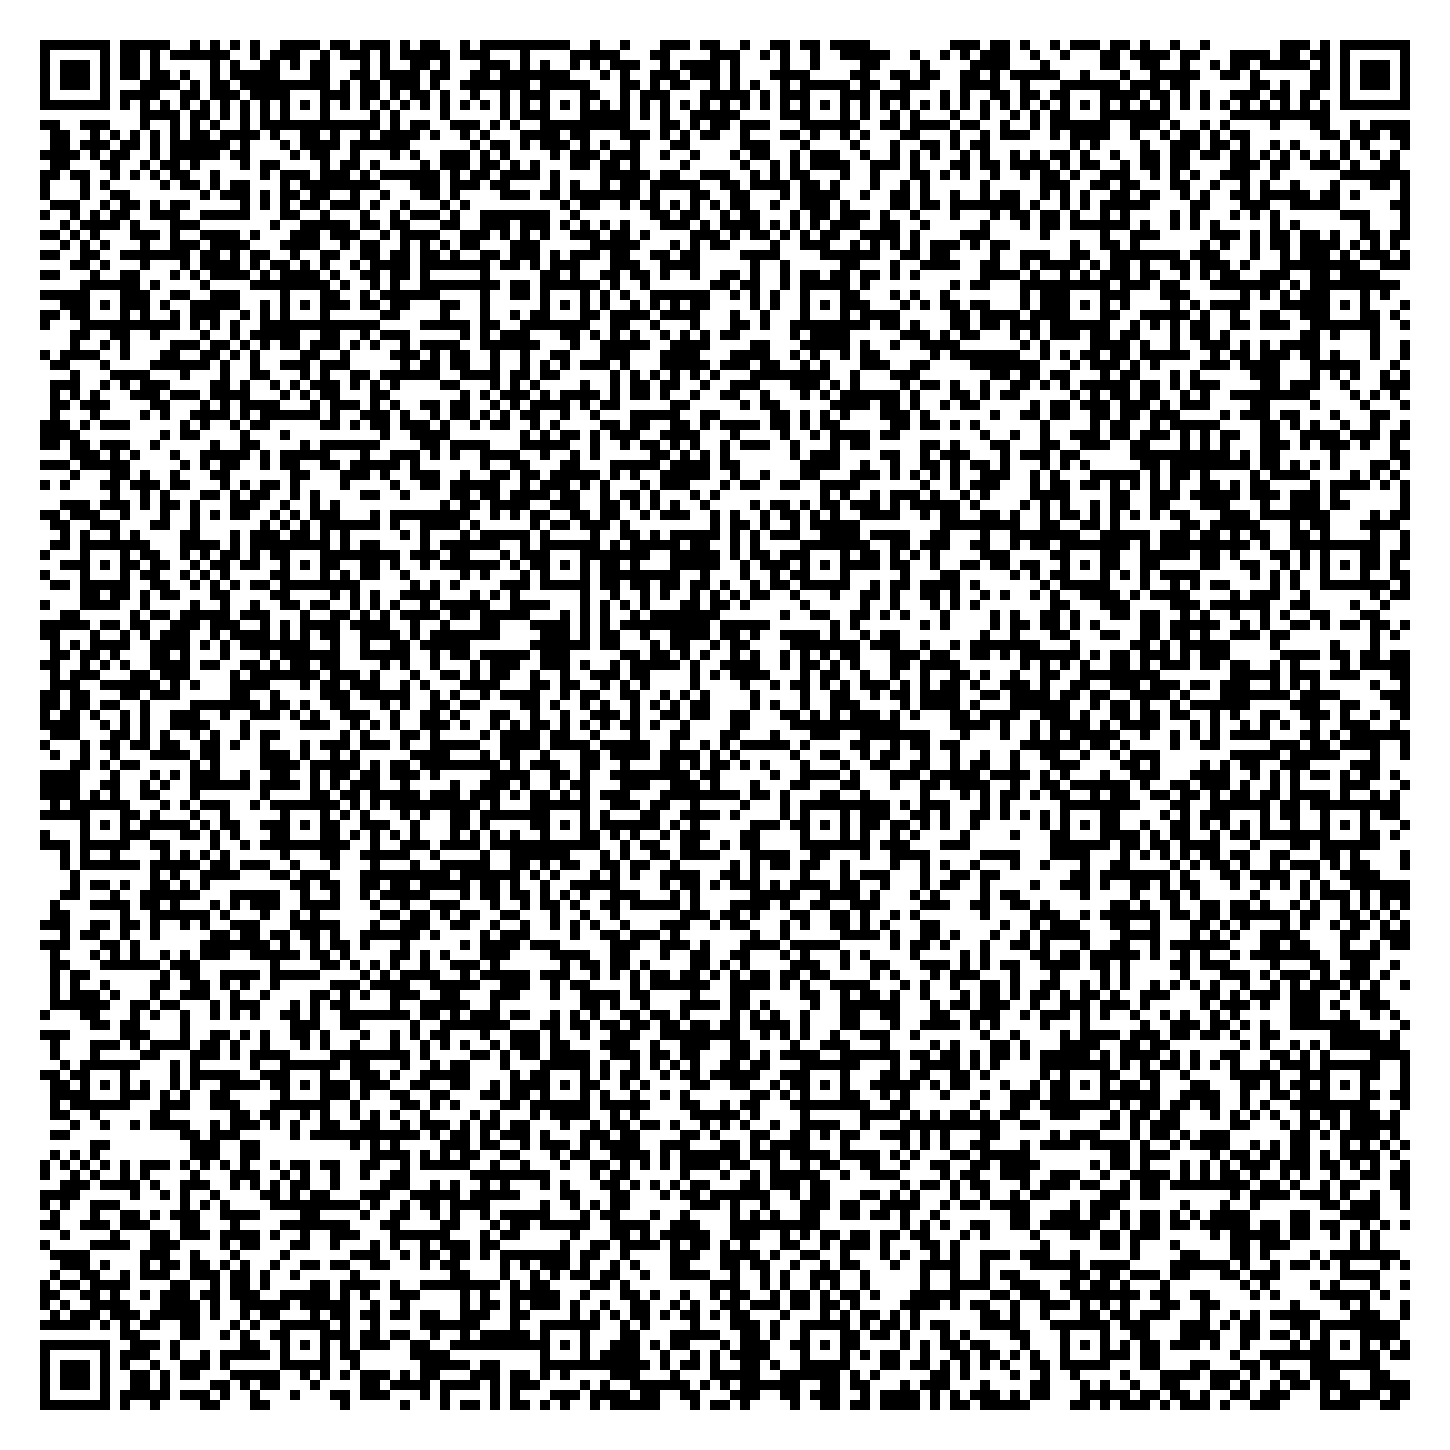

In [47]:
import qrcode
import json
import base64
import os
import binascii
from IPython.display import display, Image # Import display and Image

# Assume we have these variables from previous steps
# (Dummy variables with the *exact lengths* from your output
#  so this script is runnable. Your notebook has the real ones.)

if 'ciphertext_kem' not in locals():
    print("Using dummy data for 'ciphertext_kem' (1088 bytes)")
    ciphertext_kem = os.urandom(1088)

if 'encrypted_aes_key' not in locals():
    print("Using dummy data for 'encrypted_aes_key' (32 bytes)")
    encrypted_aes_key = os.urandom(32)

if 'encrypted_data' not in locals():
    print("Using dummy data for 'encrypted_data' (60 bytes)")
    encrypted_data = os.urandom(60)


print("Bundling Payload")

# 1. Convert all binary data to Base64 text strings
# .b64encode() returns bytes, so we .decode('utf-8') to get a string
b64_kem = base64.b64encode(ciphertext_kem).decode('utf-8')
b64_key = base64.b64encode(encrypted_aes_key).decode('utf-8')
b64_data = base64.b64encode(encrypted_data).decode('utf-8')

print("Successfully encoded all 3 components into Base64 strings.")

# 2. Create a Python dictionary (which will become our JSON)
payload_dict = {
    "kem_ciphertext": b64_kem,
    "enc_aes_key": b64_key,
    "enc_data": b64_data
}

# 3. Serialize the dictionary into a single JSON string
# This is the final string we will put in the QR code.
final_payload_string = json.dumps(payload_dict)

print(f"\nTotal payload string length: {len(final_payload_string)} characters")

# Generating the QR Code Image
print("Generating QR code image...")

qr = qrcode.QRCode(
    version=None, # Let the library auto-detect the size
    error_correction=qrcode.constants.ERROR_CORRECT_L, # L = Low (7%)
    box_size=10,
    border=4,
)

# Add our JSON string as the data
qr.add_data(final_payload_string)
qr.make(fit=True)

# Create the image
img = qr.make_image(fill_color="black", back_color="white")

# Define the filename
qr_filename = "quantum_qr.png"

# Save the image
img.save(qr_filename)

print(f"\n Success! '{qr_filename}' has been saved.")

# Display the image in the notebook
print("\nDisplaying QR code in notebook output:")
display(Image(qr_filename))

In [49]:
import json
import base64
import binascii
from pyzbar.pyzbar import decode
from PIL import Image
from pqc.kem import kyber768
from cryptography.hazmat.primitives.ciphers.aead import AESGCM

# Helper function for XORing bytes
def xor_bytes(b1, b2):
    """Performs a bitwise XOR on two equal-length byte strings."""
    if len(b1) != len(b2):
        raise ValueError("Byte strings must be of equal length to XOR")
    return bytes(x ^ y for x, y in zip(b1, b2))

# THE RECEIVER'S SECRET KEY
# 1. PASTE YOUR 'receiver_secret_key' HERE
# Get this from the output of your Step 3 script.
# It's a very long hex string.
secret_key_hex = "102a5f3d190139488d7fe80f07c712a5976457c9104e927e62c5a6e0e2aacc1cbd1f315fdeb5cca580297948c7f2647495fc2b34ca6f2fe2171d07303b60434c296f3be4344a2641f3369712f26eba58b9aa6897e8a21ab7aa3d56937c3f26c9fd20bda7aa9a7f647df0aba201302a089b5ab2436bca632677539d9ee14419dc58780628a98920a467822bfb742762995fd1bf70f4bc4a58ab0c2331f4e8040b488e9b990ea129716cc99305c8747f428c8707c1a52cb42de6448445cc257a9e797131e1424cf0a120711170287a040b1bb4dfe968ed07198873785e072df5c830bc48b6f11cb161ec6a566047264a99a61a6c4838631f027c9a8c8f14302d61862902913a5688a4f5581d77028edac77466c64e267374b957a50a624330430b0c90aaae01be93a5958584bcf0595c551526eeb029d479571bb946559a7be255a25bc2106f11b2a0c42d607227d631078b15c728a4896234b2ec5a6392357cae777d51690af430921f8c0d7f4318cdc74fdbaa71eab9aea2562eb33c5ab3c67967999011528b7315356a5b8d907198d4247b27881ecc47a017db6991364dd99524a6475ed1c35749ab29a12b00a2a5016ac63087818fe60880029667ea382e6bb0632947bebf6c6d3e3829261c5822e95740a4ca4e93ba03d16cf8b95a13cc9190076ee16b77ed07c5bcf558228b802d3b627665998fa740a4f4c154da9c26f37a6394969f5b327506525d7c5df558bf9a76c635c856d0e9a170a124a14481a516874f1c1c796690156b82b991b753c26bb4e8561e9b6c17391f5aebadc5c2ada621a82986a92e837f140c64cd29836ff389ba60110fec7059e7c0c4e97f8f693f9c595518f8b661a92426228cd1752bca0a6a2f13cad00644275753007d2a6da28369064ef8a9085227a9d15a4e5fd1a3a1b1c0b35205dad7901d76b1899c31251b4319163103455576f52b24e65f9a88caa4938c9de5577eec8348dca5fe99a58a7b19b8244dc67618f6f7630db7bd2d67cfdd60013a851610106eab543778830af690b318bc6ef47ac53e05b8f2909e5bf1bf8bc7675d63104068ca2f48567f887a81e96c1a2037efd86496f1625dc1c33a963b9467bbe976ac60e08c99d4a375557a65895b32aaaad9835506b3250fe45f48a3500b4b1d34257f31842887601116024319829c81aac3ed930920338f230a272ad7a018ab75f1d4c86ef0661c673b9c486004f14e370688748212a75922e0e633bb15cd54f6555048248f2359a20a21b5d252d792923aea20c8d60c74994dfe680357d6249258cf9a71356e860d6f1babea4b4fb45c15a6d153d2c30bd538bfa8428df0269398a10a3e435b884baacc577b1e282b2ce26c2ad39d469830db1750887c88ac95066e2b16069b1b1c52b61f5acf0a898dda40b9aa5a04e9a9344aa8b4a729bdcc8577736a77fe95a39d54bb93ac2813159db02c4ca31a5a94865a207c7f9a2b36efdb2e90d4761bf1b4792a9b4ff214134253e4273762d8ad9d637234c9a05b02be1b83214dd24ff831be51e66f26385d96160c75517fad652a2c7505400cc1a9038b06925051f81239d52d36aacb8fb18de48cbfaac762909bcca12070faa16b023c16b39b15e570607b225cc5461bd358252d04b479d32940306b4850bc13a154f222b10401403767bc68c441651c614f191258172c722a45d041b8ecfb6c02a9b5cd960a40db54dc5694aeb3b1a52598c8b9b93de2afa6526a38980017f3843022353b0a7ae6164039c46616e7cd3c85b6958bcd4e04382aa823d61a46b2228d51189ff09c6953345d3de3c938b76cc72215a4e4394ef36f512334d9ca7eecfa0f8e9c2e90e9679d8b70746758a02373e4552ae08b7908f1111605c255948016e8b2368a3e08ac282ee189a2a72f15574ed0c5904832559341746b5887167798d4d313e20a5b0699a82057c4b59026d9a4411d21961c883d4d99a206da46a9635aaa63998048bc14eb859ad86557227121f3315aeb097366086baa7b063275414c7bb7986de9d9c781c734b2065f82474459ab25c891bf371b4e84607e23b1359e8b699e066e6ab4ba04da98f79c498e23806533cadc7845ae1c68c38257a2079bb869992f485b1fa0cd0ba78bd5238cb8bc0529ab8b616575cd1750ffe69febe9aa2b96966dd170a2b745043a46738a3d6ba2a8dd613a7656b0298058003d9b46f16e71a555052594b0235828d66a8b2c3cfef20c5664059fb1097c818f63a058aef4a7daab6641822b21367de0ca624ab22ec343b185388cd1297e09f5ca71da8b6e03942eb8a790f13d2e3115fcd5a9bb09c5a5d030b3f70fff4c91ad0430305b488e0a5fcc171a2deb684d887839c85d5d969e397cccac442c83c860b2e08b6b66be14904f7153c40390ae3ce4a4bcca7f7e0906ba541e9b5912fec550c84a3beb65c1adb1bc4789124e0a8f3ad2c06d4c1921aba0ef776a30d3668817c1619bba93c99841bc0b033a13c8424e6d8273ffdb13830cadaa6628ac1cbd5b692882da3afd95177d74463e0305009825a9478371d059f05262c8aaafe873bd62d69f18d7247850c46aa71909d285d534429dc99be94030b0e8b03eab34b2591993b6a42deb6e0baa51e47a2d6845061ea9a639a107bd883b3e7c21604c57de541b52013dd9a384eb75aaeeabb4b5f796579500105039032bc0ccd94e5bc55d1fb419adc463bbab46e1202ea2b29e2dba1c3c35bf94b41cd9602aec810540104cefb3ad7aba7d7f772c65763322834b9e3678cf3ac3c822a7b1684e5b7012a99c2b52520b744912f807211b4b41a411331529169ce0b1c00b2c3563bd31aa5d89c8cb6a492c12ab0dcc35cb082b0d23447a713587d765670c80a459e339b8b622bfb71678e3931bd80c2ff090dba97391fa11971806017559b4736e19e165134aaa8333401a354fd2183022fc257b606ac7ba3e92ec0e15d9273ef05178619b7cd31068a7596b944648a3187c441eaa345e2ea34ff12403ccc14dd7846a90173a39c5812e227799abb99997118e9cb6650881d64bbe97d5be37a6c1b6e0b66f0319a3032135910a90ac42a3ba2ce71a05b0aa9be933813b68435e918c063037c890a525eac8189678ba0720870a47d64330a8c7895070c7f78821b921bf3355c7780787ff796df77b49b82c2c13c51ada62b5b4b94ff089a48e86532cb155fd167b1ad6b682c3a46d9538fc8341665a6e56f4493f441cc60babcfbc9f46247ccbd09a3b6a7a1ffbf05a69d45eb2c5ff36d14d7ba31475987b78cfc1d31ebf633c2a8b1553b0e9906be95e6a4ee97cbddf1e98323f38c47c2a7a78201bcad54473a7ddaf9f7509bf9eea3a9d1ceb2d1b26407f0b1dbbf49cf012e467adafe9edc29b11a5707a"
# 2. Convert the hex string into raw bytes
try:
    receiver_secret_key = binascii.unhexlify(secret_key_hex)
    print(f"Loaded {len(receiver_secret_key)}-byte receiver secret key.")
except (binascii.Error, ValueError):
    print("!!! ERROR !!!")
    print("You must paste your hex 'receiver_secret_key' into the script.")
    print("The script cannot decrypt without it. Please edit the file and try again.")
    exit()

# 1. Read and Parse the QR Code
try:
    print("\nScanning 'quantum_qr.png'...")
    qr_data = decode(Image.open('quantum_qr.png'))
    final_payload_string = qr_data[0].data.decode('utf-8')

    print("Successfully read QR code data.")
    payload_dict = json.loads(final_payload_string)

    # 2. Unpack and Base64-Decode the 3 components
    ciphertext_kem_bytes = base64.b64decode(payload_dict["kem_ciphertext"])
    enc_aes_key_bytes = base64.b64decode(payload_dict["enc_aes_key"])
    enc_data_bytes = base64.b64decode(payload_dict["enc_data"])

    print("Successfully parsed JSON and decoded Base64 components.")

except FileNotFoundError:
    print("ERROR: 'quantum_qr.png' not found. Make sure it's in the same directory.")
    exit()
except Exception as e:
    print(f"An error occurred reading or parsing the QR code: {e}")
    exit()

# 3. Decrypt the AES Key (PQC Step)
print("\nPerforming PQC decapsulation to recover AES key...")

# Use the receiver's secret key to "unlock" the KEM ciphertext.
# This recovers the *exact same* shared secret the sender used.
shared_secret_kem = kyber768.decap(ciphertext_kem_bytes, receiver_secret_key)

# Reverse the XOR to get back the original Qiskit-generated key
recovered_aes_key = xor_bytes(enc_aes_key_bytes, shared_secret_kem)

print(f"Successfully recovered the {len(recovered_aes_key)}-byte AES key.")
print(f"Recovered AES Key (hex): {binascii.hexlify(recovered_aes_key).decode('utf-8')}")

# 4. Decrypt the Final Message (AES Step)
print("\nPerforming AES decryption to recover secret message...")

try:
    # Remember from Step 2: the first 12 bytes are the nonce.
    nonce = enc_data_bytes[:12]
    ciphertext_and_tag = enc_data_bytes[12:]

    aesgcm = AESGCM(recovered_aes_key)

    # Decrypt the data. This will fail if the key is wrong.
    decrypted_bytes = aesgcm.decrypt(nonce, ciphertext_and_tag, None)

    # Convert from bytes back to a readable string
    secret_message = decrypted_bytes.decode('utf-8')

    print("\n DECRYPTION SUCCESSFUL ")
    print(f"The secret message is: {secret_message}")

except Exception as e:
    print("\n DECRYPTION FAILED")
    print(f"An error occurred: {e}")
    print("This usually means the wrong secret key was used or the data was tampered with.")

Loaded 2400-byte receiver secret key.

Scanning 'quantum_qr.png'...
Successfully read QR code data.
Successfully parsed JSON and decoded Base64 components.

Performing PQC decapsulation to recover AES key...
Successfully recovered the 32-byte AES key.
Recovered AES Key (hex): b0ccc312b2b4b6cca4297c0114a8082c7bb30fe349a523486405bbcd27c7670f

Performing AES decryption to recover secret message...

 DECRYPTION SUCCESSFUL 
The secret message is: Let's show Quantum Advantage
